In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import tqdm

data_path = "./data/"

In [2]:
orig_lena = cv.imread(data_path + "lena.png")

### Original image

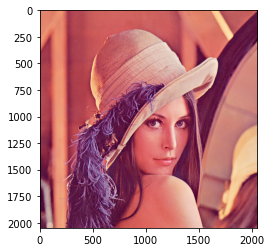

In [3]:
plt.imshow(cv.cvtColor(orig_lena, cv.COLOR_BGR2RGB))

### Haar face detection

Found face at [915, 850] of size 612 x 612


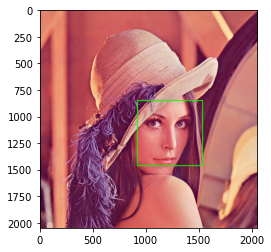

In [4]:
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
faces_found = face_cascade.detectMultiScale(cv.cvtColor(orig_lena, cv.COLOR_BGR2GRAY))
indent_perc = 0.15  # 10% is too few

lena_faces = orig_lena.copy()
for (x, y, w, h) in faces_found:
    print(f"Found face at [{x}, {y}] of size {w} x {h}")
    cv.rectangle(lena_faces, (x, y), (x+w, y+h), (0, 255, 0), 8)
    x_indent = int(w * indent_perc)
    y_indent = int(h * indent_perc)
    lena_last_face = orig_lena[y - y_indent:y + h + y_indent, x - x_indent:x + w + x_indent]
plt.imshow(cv.cvtColor(lena_faces, cv.COLOR_BGR2RGB))

Rectangle [824, 759] : [1618, 1553] was taken


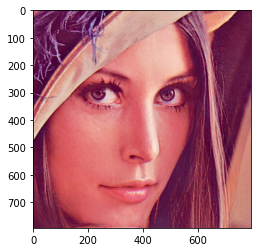

In [5]:
print(f"Rectangle [{x - x_indent}, {y - y_indent}] : [{x + w + x_indent}, {y + h + y_indent}] was taken")
plt.imshow(cv.cvtColor(lena_last_face, cv.COLOR_BGR2RGB))

plt.imshow(cv.cvtColor(orig_lena, cv.COLOR_BGR2RGB))

### Canny edge detection

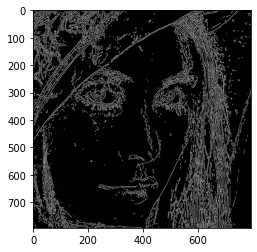

In [6]:
lena_edges = cv.Canny(cv.cvtColor(lena_last_face, cv.COLOR_BGR2GRAY), 50, 80)
plt.imshow(lena_edges, cmap="gray")

### Find contours (noise cancellation)

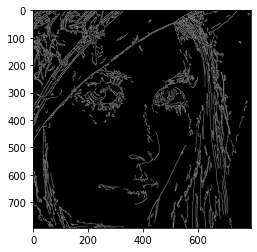

In [7]:
min_edge_size = 8  # 10 is too many

contours_image = np.zeros(lena_edges.shape, np.uint8)
contours, _ = cv.findContours(lena_edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    _, _, w, h = cv.boundingRect(c)
    if w >= min_edge_size and h >= min_edge_size:
        cv.drawContours(contours_image, contours, i, (255, 255, 255), 1)
plt.imshow(contours_image, cmap="gray")

### Morph. dilation

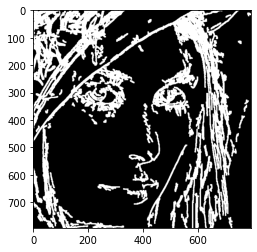

In [8]:
dilation_kernel = np.ones((5, 5), np.uint8)
dilated_image = cv.dilate(contours_image, dilation_kernel)
plt.imshow(dilated_image, cmap="gray")

### Gaussian bluring

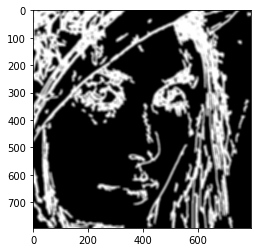

In [9]:
blurryface = cv.GaussianBlur(dilated_image, (11, 11), 10)  # kernel of size 11 * 11 is better for our image
norm_blurryface = np.zeros(blurryface.shape, np.float32)
cv.normalize(blurryface, norm_blurryface, 0, 1, cv.NORM_MINMAX, cv.CV_32F)
plt.imshow(norm_blurryface, cmap="gray")

### Original face once again

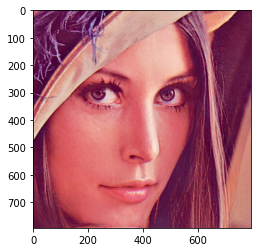

In [10]:
plt.imshow(cv.cvtColor(lena_last_face, cv.COLOR_BGR2RGB))

### Bilaterial filtering (F1)

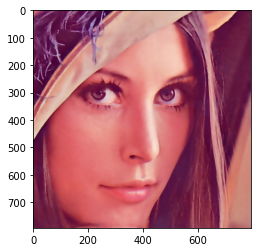

In [11]:
f1_image = cv.bilateralFilter(lena_last_face, 15, 75, 75)
plt.imshow(cv.cvtColor(f1_image, cv.COLOR_BGR2RGB))

### Sharpness increasing (F2)

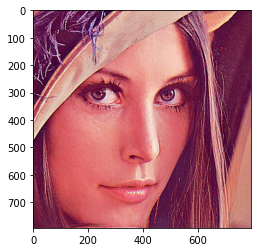

In [12]:
blurryface_lena = cv.GaussianBlur(lena_last_face, (5, 5), 2)
f2_image = cv.addWeighted(lena_last_face, 3.5, blurryface_lena, -2.5, 0)
plt.imshow(cv.cvtColor(f2_image, cv.COLOR_BGR2RGB))

### Final image

100%|██████████| 794/794 [00:17<00:00, 44.88it/s]


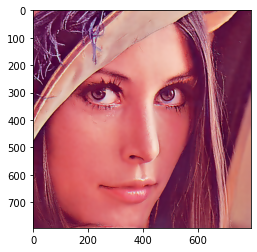

In [14]:
final_lena = np.zeros(lena_last_face.shape, np.uint8)

with tqdm.tqdm(total=norm_blurryface.shape[0]) as pbar:
    for x in range(norm_blurryface.shape[0]):
        for y in range(norm_blurryface.shape[1]):
            for ch in range(3):
                final_lena[x,y,ch] = norm_blurryface[x, y] * f2_image[x, y, ch] + (1 - norm_blurryface[x, y]) * f1_image[x, y, ch]
                if final_lena[x,y,ch] > 255:
                    final_lena[x,y,ch] = 255
                elif final_lena[x,y,ch] < 0:
                    final_lena[x,y,ch] = 0
        pbar.update(1)
plt.imshow(cv.cvtColor(final_lena, cv.COLOR_BGR2RGB))